In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the dataset class
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, set_number, sample_rate=16000, n_mfcc=13, n_mels=128):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        return [idx for idx in range(len(self.data)) if int(self.data.iloc[idx, 1]) == self.set_number]

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        class_label = int(self.data.iloc[idx, 2]) 
        try:
            waveform, _ = librosa.load(file, sr=self.sample_rate)
            spectrogram = librosa.feature.melspectrogram(y=waveform, sr=16000, n_mels=128, hop_length=128, n_fft=2048)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrogram = np.expand_dims(spectrogram, axis=0)  # Add channel dimension
            return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(class_label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            return self.__getitem__((idx + 1) % len(self.filtered_indices))  # Load next sample

# Load the datasets
csv_file = 'dataset_2.csv'
root_dir = 'dataset'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)

In [3]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):

    print(X.shape, y.shape)
    if batch == 3:
        break

#dimensiuni: cat mai patrat - 128x128
    

torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models


def get_vgg(version=16, freeze=False, num_classes=10, device='cpu', pretrained=None):
    vgg = models.__dict__[f'vgg{version}'](pretrained=True)
    
    if freeze:
        for param in vgg.parameters():
            param.requires_grad = False
    
    # Modify the first convolutional layer to accept 1 input channel
    vgg.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
    # Modify the fully connected layer to match the number of classes
    vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=num_classes, bias=True)
    
    if pretrained:
        vgg.load_state_dict(torch.load(pretrained))
    
    return vgg.to(device)

model = get_vgg(version=16, freeze=False, num_classes=10, device=device)
print(model)

c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate
criterion = nn.CrossEntropyLoss()

In [6]:

# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    train_losses = []
    train_accuracies = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data =data.repeat(1, 3, 1, 1)
        # data = data.squeeze(1)  # Remove channel dimension
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    scheduler.step()
    return avg_loss, accuracy

In [7]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

all_preds = []
all_targets = []
# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_losses = []
    test_accuracies = []
   
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.repeat(1, 3, 1, 1)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return avg_test_loss, accuracy, all_preds, all_targets


In [8]:
n_epoch = 5
log_interval = 20

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    all_preds = []
    all_targets = []
    for epoch in range(1, n_epoch + 1):
        loss, acc = train(model, device, train_loader, optimizer, epoch, log_interval, scheduler)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(acc)

        loss, acc, preds, targets = test(model, device, test_loader)
        test_epoch_losses.append(loss)
        test_epoch_accuracies.append(acc)
        torch.save(model.state_dict(), 'vgg_gsc.pt')
        pbar.update(1)


  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/13363 (0%)]	Loss: 9.367811
Train Epoch: 1 [1280/13363 (10%)]	Loss: 1.130622
Train Epoch: 1 [2560/13363 (19%)]	Loss: 0.915733
Train Epoch: 1 [3840/13363 (29%)]	Loss: 0.322578
Train Epoch: 1 [5120/13363 (38%)]	Loss: 0.317012
Train Epoch: 1 [6400/13363 (48%)]	Loss: 0.365253
Train Epoch: 1 [7680/13363 (57%)]	Loss: 0.182257
Train Epoch: 1 [8960/13363 (67%)]	Loss: 0.235622
Train Epoch: 1 [10240/13363 (77%)]	Loss: 0.118661
Train Epoch: 1 [11520/13363 (86%)]	Loss: 0.140623
Train Epoch: 1 [12800/13363 (96%)]	Loss: 0.126109

Test set: Average loss: 0.1387, Accuracy: 3633/3818 (95%)



 20%|██        | 1/5 [1:00:19<4:01:18, 3619.65s/it]

Train Epoch: 2 [0/13363 (0%)]	Loss: 0.101584
Train Epoch: 2 [1280/13363 (10%)]	Loss: 0.145650
Train Epoch: 2 [2560/13363 (19%)]	Loss: 0.131156
Train Epoch: 2 [3840/13363 (29%)]	Loss: 0.083776
Train Epoch: 2 [5120/13363 (38%)]	Loss: 0.261025
Train Epoch: 2 [6400/13363 (48%)]	Loss: 0.002882
Train Epoch: 2 [7680/13363 (57%)]	Loss: 0.089772
Train Epoch: 2 [8960/13363 (67%)]	Loss: 0.180152
Train Epoch: 2 [10240/13363 (77%)]	Loss: 0.161622
Train Epoch: 2 [11520/13363 (86%)]	Loss: 0.103236
Train Epoch: 2 [12800/13363 (96%)]	Loss: 0.077106

Test set: Average loss: 0.1124, Accuracy: 3677/3818 (96%)



 40%|████      | 2/5 [3:01:32<4:48:26, 5768.70s/it]

Train Epoch: 3 [0/13363 (0%)]	Loss: 0.022984
Train Epoch: 3 [1280/13363 (10%)]	Loss: 0.041774
Train Epoch: 3 [2560/13363 (19%)]	Loss: 0.239789
Train Epoch: 3 [3840/13363 (29%)]	Loss: 0.182438
Train Epoch: 3 [5120/13363 (38%)]	Loss: 0.018392
Train Epoch: 3 [6400/13363 (48%)]	Loss: 0.110310
Train Epoch: 3 [7680/13363 (57%)]	Loss: 0.113402
Train Epoch: 3 [8960/13363 (67%)]	Loss: 0.148067
Train Epoch: 3 [10240/13363 (77%)]	Loss: 0.016632
Train Epoch: 3 [11520/13363 (86%)]	Loss: 0.026925
Train Epoch: 3 [12800/13363 (96%)]	Loss: 0.104093

Test set: Average loss: 0.0898, Accuracy: 3700/3818 (97%)



 60%|██████    | 3/5 [4:04:26<2:41:55, 4857.63s/it]

Train Epoch: 4 [0/13363 (0%)]	Loss: 0.022064
Train Epoch: 4 [1280/13363 (10%)]	Loss: 0.002436
Train Epoch: 4 [2560/13363 (19%)]	Loss: 0.034772
Train Epoch: 4 [3840/13363 (29%)]	Loss: 0.065704
Train Epoch: 4 [5120/13363 (38%)]	Loss: 0.034752
Train Epoch: 4 [6400/13363 (48%)]	Loss: 0.016522
Train Epoch: 4 [7680/13363 (57%)]	Loss: 0.078324
Train Epoch: 4 [8960/13363 (67%)]	Loss: 0.067044
Train Epoch: 4 [10240/13363 (77%)]	Loss: 0.025447
Train Epoch: 4 [11520/13363 (86%)]	Loss: 0.029298
Train Epoch: 4 [12800/13363 (96%)]	Loss: 0.036338

Test set: Average loss: 0.0903, Accuracy: 3711/3818 (97%)



 80%|████████  | 4/5 [5:35:17<1:24:51, 5091.96s/it]

Train Epoch: 5 [0/13363 (0%)]	Loss: 0.029262
Train Epoch: 5 [1280/13363 (10%)]	Loss: 0.150624
Train Epoch: 5 [2560/13363 (19%)]	Loss: 0.028893
Train Epoch: 5 [3840/13363 (29%)]	Loss: 0.046737
Train Epoch: 5 [5120/13363 (38%)]	Loss: 0.030802
Train Epoch: 5 [6400/13363 (48%)]	Loss: 0.049627
Train Epoch: 5 [7680/13363 (57%)]	Loss: 0.148369
Train Epoch: 5 [8960/13363 (67%)]	Loss: 0.007882
Train Epoch: 5 [10240/13363 (77%)]	Loss: 0.063063
Train Epoch: 5 [11520/13363 (86%)]	Loss: 0.029631
Train Epoch: 5 [12800/13363 (96%)]	Loss: 0.046405

Test set: Average loss: 0.0918, Accuracy: 3720/3818 (97%)



100%|██████████| 5/5 [6:35:06<00:00, 4741.33s/it]  


              precision    recall  f1-score   support

        stop       0.97      0.97      0.97      3885
          up       0.96      0.96      0.96      3580
        down       0.99      0.97      0.98      3910
        left       0.98      0.95      0.96      3955
       right       0.94      0.98      0.96      3760

    accuracy                           0.97     19090
   macro avg       0.97      0.97      0.97     19090
weighted avg       0.97      0.97      0.97     19090

[[0.96911197 0.00694981 0.001287   0.01364221 0.00900901]
 [0.0103352  0.9622905  0.00614525 0.00223464 0.01899441]
 [0.0084399  0.01355499 0.96930946 0.00102302 0.00767263]
 [0.00733249 0.00960809 0.00202276 0.95094817 0.0300885 ]
 [0.00744681 0.00558511 0.00239362 0.00585106 0.9787234 ]]


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1c698dba910>,
 None)

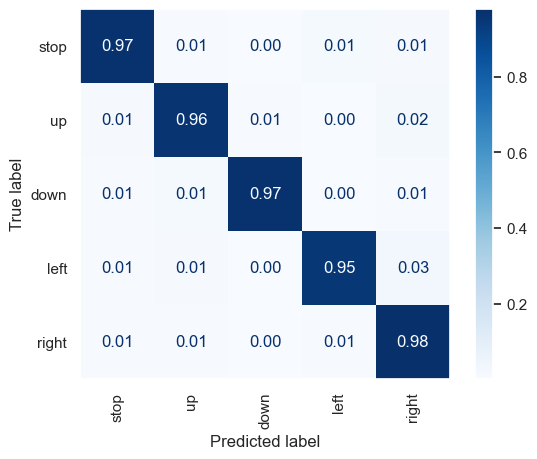

In [12]:
from sklearn.metrics import classification_report

report = classification_report(all_targets, all_preds, target_names=['stop', 'up', 'down', 'left', 'right'])  # Adjust target_names based on your dataset
print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
#normalize the confusion matrix
confision_matrix = confision_matrix.astype('float') / confision_matrix.sum(axis=1)[:, np.newaxis]

#print confusion matrix and labels
print(confision_matrix)


# confusion matrix display using sklearn 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the confusion matrix is stored in the variable confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confision_matrix, display_labels=['stop', 'up', 'down', 'left', 'right'])

#rempove the grid lines from the confusion matrix 
disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical', ax=None), plt.grid(False)


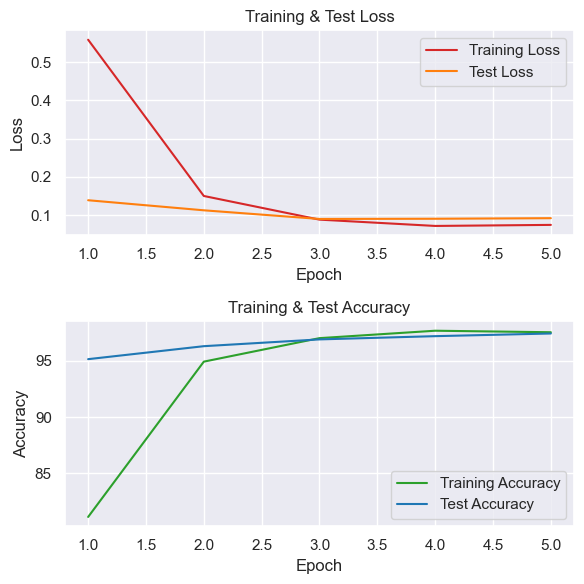

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Assuming the number of epochs is the length of the longest list
num_epochs = 100
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplot
axs[0].plot(epochs[:len(train_epoch_losses)], train_epoch_losses, label='Training Loss', color='tab:red')
axs[0].plot(epochs[:len(test_epoch_losses)], test_epoch_losses, label='Test Loss', color='tab:orange')
axs[0].set_title('Training & Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_epoch_accuracies)], train_epoch_accuracies, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_epoch_accuracies)], test_epoch_accuracies, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()